## Initialisation

In [128]:
import random
import time
import pprint

from matplotlib import pyplot as plt
from pymongo import MongoClient
import numpy as np


# Init
mongo = MongoClient('localhost', 27017)
db = mongo['citeos']
collection_villes = db['villes']
collection_routes = db['routes']
collection_clients = db['clients']

num_clients_FR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'frais'}}])))
num_clients_PA = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'particulier'}}])))
num_clients_PR = list(map(lambda x: x['id_client'], collection_clients.aggregate([{"$match" : {'est_client': True, 'type': 'prisonnier'}}])))

num_clients_FR.append(0)
num_clients_PA.append(0)
num_clients_PR.append(0)

roads_FR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_FR}, 'id_ville_2': {'$in': num_clients_FR}})))
roads_PA = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PA}, 'id_ville_2': {'$in': num_clients_PA}})))
roads_PR = np.array(list(collection_routes.find({'id_ville_1': {'$in': num_clients_PR}, 'id_ville_2': {'$in': num_clients_PR}})))

num_clients_FR.remove(0)
num_clients_PA.remove(0)
num_clients_PR.remove(0)

## Fonction Voisin

In [110]:
def neighborhood(circuit):
    """
    Cette fonction est un generateur de tous les voisins valides d'une solution
    """
    for i in range (1, len(circuit) - 2):
        neighbor_circuit = circuit.copy()
        neighbor_circuit[i], neighbor_circuit[i + 1] = neighbor_circuit[i + 1], neighbor_circuit[i]
        yield neighbor_circuit

## Fonction Recuperation Routes

In [111]:
def import_roads(cities):
    cities.append(0)
    return np.array(list(collection_routes.find({'id_ville_1': {'$in': cities}, 'id_ville_2': {'$in': cities}})))

## Fonction Score

In [112]:
def circuit_score(circuit, roads):
    """
    Cette fonction retourne le score d'un circuit eulerien, cela permettra de comparer les differents voisins entre eux
    """
    score = 0
    for i in range(0, len(circuit) - 1):
        #on recupere la bonne route
        road = next(item for item in roads if (item["id_ville_1"] == circuit[i] and item["id_ville_2"] == circuit[i + 1]) or (item["id_ville_1"] == circuit[i + 1] and item["id_ville_2"] == circuit[i]))
        #on verifie si la route est oriente ou non, si oui, on cherche le bon sens
        if road['est_oriente']: score += road['poids_1'] if road['id_ville_1'] == circuit[i] else road['poids_2']
        else: score += road['poids']
    return score

## Recherche Tabou

In [113]:
def tabu_search(initial_circuit, tabu_size, max_iteration, actual_roads):
    iteration = 1
    tabu_list = list()
    actual_circuit = initial_circuit.copy()

    best_actual_circuit = initial_circuit.copy()
    best_total_circuit = initial_circuit.copy()
    best_total_value = circuit_score(best_total_circuit, actual_roads)

    best_total_list = list()
    best_actual_list = list()

    while iteration <= max_iteration:
        iteration += 1
        best_actual_value = -1

        # on parcourt les voisins de la solution courante
        for neighbor in neighborhood(actual_circuit):
            if neighbor not in tabu_list and (circuit_score(neighbor, actual_roads) <= best_actual_value or best_actual_value == -1):
                best_actual_value = circuit_score(neighbor, actual_roads)
                best_actual_circuit = neighbor.copy()

        # on met a jour la meilleur solution rencontree depuis le debut
        if best_actual_value < best_total_value:
            best_total_circuit = best_actual_circuit.copy()
            best_total_value = best_actual_value

        best_total_list.append(best_total_value)
        best_actual_list.append(best_actual_value)

        actual_circuit = best_actual_circuit.copy()

        if len(tabu_list) >= tabu_size: tabu_list.pop(0)
        tabu_list.append(actual_circuit.copy())

    return best_total_circuit, best_total_list, best_actual_list

## Multi-start

In [114]:
def tabu_multi_start(number, iteration, shuffled, actual_roads):
    best_local_score = -1
    best_local_circuit = []
    for i in range(0, number):
        shuffled_circuit = shuffled.copy()
        shuffled_circuit.append(0)
        shuffled_circuit.insert(0, 0)
        bc, bt, ba= tabu_search(shuffled_circuit, 100, iteration, actual_roads)
        actual_score = circuit_score(bc, actual_roads)

        if best_local_score == -1 or actual_score < best_local_score:
            best_local_score = actual_score
            best_local_circuit = bc

    return best_local_circuit, best_local_score

## Graphe vers circuits

In [125]:
k = 30

len(num_clients_FR)
#roads_FR

def create_circuits(clients_list, roads_list, k):
    total_of_clients = sum(len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR])
    number_of_clients = [len(client_list) for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]
    trucks_for_lists = [int(k * percentage) for percentage in [len(client_list) / total_of_clients for client_list in [num_clients_FR, num_clients_PA, num_clients_PR]]]
    while sum(trucks_for_lists) != k: trucks_for_lists[random.randint(0, len(trucks_for_lists) - 1)] += 1

    origins = [0,0,0]
    clients_per_k = [noc // tfl for noc, tfl in zip(number_of_clients, trucks_for_lists)]
    difference = [noc % cpk for noc, cpk in zip(number_of_clients, clients_per_k)]


    best_circuits = [[] for _ in range (len(clients_list))]

    for idx, client_list in enumerate(clients_list):
        passed = [origins[idx],]
        actual_node = random.choice(client_list)
        for truck in range(0, trucks_for_lists[idx]):

            truck_circuit = [actual_node,]
            passed.append(actual_node)

            while len(truck_circuit) != clients_per_k[idx]:
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if difference[idx] > 0:
                difference[idx] -= 1
                truck_circuit.append(get_closer_node(truck_circuit[-1], roads_list[idx], passed))
                passed.append(truck_circuit[-1])

            if len(truck_circuit) % 6 == 0:
                actual_node = get_closer_node(truck_circuit[0], roads_list[idx], passed)
            else:
                actual_node = get_closer_node(truck_circuit[-1], roads_list[idx], passed)
            best_circuits[idx].append(truck_circuit)
    return best_circuits

## Glouton

In [116]:
def get_closer_node(node, roads, ignored):
    min_weight = -1
    next_node = 0
    roads = [r for r in roads if r["id_ville_1"] not in ignored or r["id_ville_2"] not in ignored]
    for road in roads:
        if road['est_oriente']:
            if (road['id_ville_1'] == node) and (min_weight == -1 or min_weight > road['poids_1']):
                min_weight = road['poids_1']
                next_node = road['id_ville_2']
            elif (road['id_ville_2'] == node) and (min_weight == -1 or min_weight > road['poids_2']):
                min_weight = road['poids_2']
                next_node = road['id_ville_1']
        elif (min_weight > road['poids'] or  min_weight == -1) and (road["id_ville_1"] == node or road["id_ville_2"] == node):
            min_weight = road['poids']
            next_node = road['id_ville_1'] if road["id_ville_2"] == node else road['id_ville_2']

    return next_node

## Tests

In [117]:
#circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], [roads_FR, roads_PA, roads_PR], k)




[[], [], []]
0
[163, 1368, 1337, 1163, 1158, 1963, 956, 1636, 1287, 898, 556, 190, 140, 328, 1240, 405, 123, 1262, 341, 157, 258, 315]
([0, 163, 1368, 1337, 1163, 1158, 1963, 956, 1636, 1287, 898, 556, 190, 140, 328, 1240, 405, 123, 1262, 341, 157, 315, 258, 0], 994)
[1217, 240, 583, 808, 558, 1164, 1649, 1318, 511, 1154, 401, 1604, 1572, 778, 1404, 704, 1208, 74, 495, 1358, 387, 585]
([0, 1217, 240, 583, 808, 558, 1164, 1649, 1318, 511, 1154, 401, 1604, 1572, 778, 1404, 704, 1208, 74, 495, 1358, 387, 585, 0], 403)
[744, 641, 124, 192, 1516, 828, 738, 587, 549, 732, 203, 1061, 269, 1843, 1120, 572, 31, 168, 1054, 377, 1756, 726]
([0, 744, 641, 124, 192, 1516, 828, 738, 587, 549, 732, 203, 1061, 269, 1843, 1120, 572, 31, 168, 1054, 377, 1756, 726, 0], 599)
[797, 1205, 1475, 347, 1416, 1687, 1252, 1045, 194, 1365, 708, 252, 1555, 1232, 1196, 77, 926, 789, 1178, 1766, 1750, 976]
([0, 1205, 797, 1475, 347, 1416, 1687, 1252, 1045, 194, 1365, 708, 252, 1555, 1232, 1196, 77, 926, 789, 1178, 1

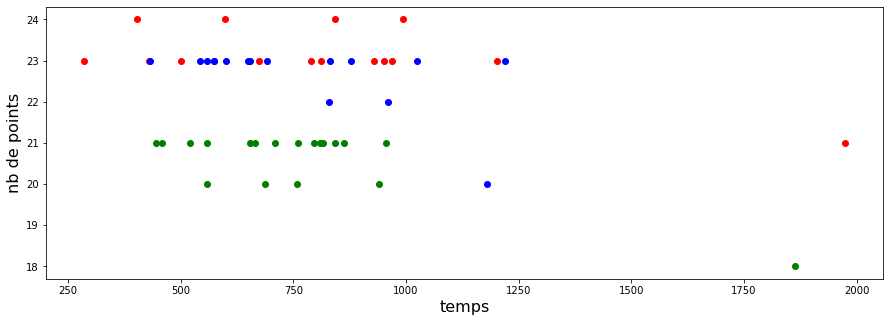

In [131]:
final = []
n = 6
it = 200
k = 50

roads_all = [roads_FR, roads_PA, roads_PR]
circuits_per_type = create_circuits([num_clients_FR, num_clients_PA, num_clients_PR], roads_all, k)

colors = ['red', 'green', 'blue']

plt.figure(figsize=(15,5))
for i, circuits in enumerate(circuits_per_type):
    print(i)
    print("===================================================================================")
    for j, circuit in enumerate(circuits):
        print(circuit)
        final.append(tabu_multi_start(n, it, circuit.copy(), import_roads(circuit.copy())))
        print(final[-1])
        plt.xlabel("temps", fontsize=16)
        plt.ylabel("nb de points", fontsize=16)
        plt.scatter(final[-1][1], len(final[-1][0]), color=colors[i],)

#print(final)